<font face="Calibri" size="2"> <i>Open SAR Toolkit - Tutorial 1, version 1.1,  November 2019. Andreas Vollrath, ESA/ESRIN phi-lab</i>
</font>

![title](auxiliary/header_image.PNG)

--------

# OST Tutorial I 
## Pre-processing your first Sentinel-1 GRD imagery with OST

--------

**Short description**

This notebook introduces you to the `Sentinel_1Scene` class of the Open SAR Toolkit and demonstrates how it can be used to download, extract metadata and pre-process a single Sentinel-1 scene.

--------

**Requirements**

- a PC/Mac with at least 16GB of RAM
- about 4 GB of free disk space
- a NASA Earthdata account with signed EULA for use of https://search.asf.alaska.edu (just register directly there)
--------

**NOTE:** all cells that have an * after its number can be executed without changing any code. 

### 1\* - Import the OST *Sentinel1_Scene* class

In [1]:
# these imports we need to handle the folders, independent of the OS
import os
from os.path import join

# this is the s1Scene class, that basically handles all the workflow from beginning to the end
from ost import Sentinel1Scene

# Check if you have SNAP GPT, kinda important
from ost.helpers.helpers import gpt_path
print(gpt_path())

/home/suprd/SNAP_Toolbox/snap/bin/gpt


### 2* - Create a folder for our outputs

By executing this cell, a new folder will be created and the path will be written to the *processing_dir* variable

In [2]:
# get home folder
home = os.getenv('HOME')
# create a processing directory
output_dir = join(home, 'OpenSarToolkit', 'Tutorial_1')
os.makedirs(output_dir, exist_ok=True)

### 3* - Choose scene ID and display some metadata

In order to initialize an instance of the *Sentinel1_Scene* class, all we need is a valid scene id of a Sentinel-1 product. 

In [3]:
# create a S1Scene class instance based on the scene identifier of the first ever Dual-Pol Sentinel-1 IW product
# cached scene
scene_id = 'S1B_IW_GRDH_1SDV_20180813T054020_20180813T054045_012240_0168D6_B775'

#scene_id = 'S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F' 
# actually only available from ASF's data archive
scene_id = 'S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F'
# create an S1Scene instance
s1 = Sentinel1Scene(scene_id)

# print summarising infos about the scene
s1.info()

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Ground Range Detected (GRD)
 Acquisition Date:        20191116
 Start Time:              170638
 Stop Time:               170703
 Absolute Orbit:          029939
 Relative Orbit:          117
 -------------------------------------------------


{'Scene_Identifier': 'S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F',
 'Satellite': 'Sentinel-1A',
 'Acquisition_Mode': 'Interferometric Wide Swath',
 'Processing_Level': '1',
 'Product_Type': 'Ground Range Detected (GRD)',
 'Acquisition_Date': '20191116',
 'Start_Time': '170638',
 'Stop_Time': '170703',
 'Absolute_Orbit': '029939',
 'Relative_Orbit': '117'}

### 4* a) - Get a scene from testdata cache (if you don't feel like downloading anything) 

Just a small subset of a GRD scene from the testdata. Ideal if you want to play around, the data is small. Ideal to check the different calirbation and DEM options at hand.

**Note:** Basically just the OST test process rewritten here.






In [4]:
# Function to confert .SAFE open folder (like a one from a DIAS) 
# to a regular .zip structure (SNAP is happier with the zips)
from ost.helpers.helpers import zip_s1_safe_dir

# This is a path to a local cache
src = os.path.join(os.getcwd(), 'testdata', 'cache', s1.scene_id)


# Copy and structurize s1 input data as it were on a bucket
download_path = os.path.join(output_dir,
                             'SAR',
                             s1.product_type,
                             s1.year,
                             s1.month,
                             s1.day
                            )
os.makedirs(download_path, exist_ok=True)
zip_s1_safe_dir(src,
                os.path.join(download_path, scene_id+'.zip.downloaded'),
                s1.scene_id
               )
zip_s1_safe_dir(src,
                os.path.join(download_path, scene_id+'.zip'),
                scene_id
                )

# Get path to the product
s1_processing_path = s1.get_path(output_dir)
print(s1_processing_path)







/home/suprd/OpenSarToolkit/Tutorial_1/SAR/GRD/2019/11/16/S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F.zip


### 4* b) - Download the/a scene direcly

The first step is to download the selected scene. In our case we chose the first regular Sentinel-1 IW product acquired in the dual-polarisation VV/VH acquired the 3rd of October 2014. 
OST provides download from 3 different mirrors, ESA's scihub, CNES PEPS and Alaska Satellite Facility (NASA Earthdata). Since ESA's official scihub became a rolling archive, and so is PEPS, best is to download from the fantastic **Alaska Satellite Facility** mirror (selection 2), which holds the full Sentinel-1 archive online. 

**Note:** At the end the downloaded file will be checked. This assures that the download went fine and we can use it for processing. In addiiton, OST will also magically remember that this file has been successfully downloaded.

In [6]:
s1.download(output_dir)

Type 1, 2 or 3: 2
Username:suprd
Password:········
1019795108


S1A_IW_GRDH_1SDV_20191116T170638_20191116T170703_029939_036AAB_070F.zip: 1.02GB [04:32, 3.74MB/s]                                


### 5* - Create an ARD product

Analysis Ready Data is interpreted differently by different persons. 

The default ARD type is *'OST Standard'*. For GRD products you can select other pre-defined ARD types, or it allows customising single ARD parameters.

See in the cell below the different definitions possible, and also note how the resolution and the resampling of the image during terrain correction is changed at the bottom. In this way, all parameters can be customised. 

In [7]:
print(' Our ARD parameters dictionary contains folowing keys.')
print(s1.ard_parameters.keys())
print('')
print(' Dictionary of our standard OST ARD parameters for the scene processing:')
print(s1.ard_parameters)
print('')


# we change ARD type
# possible coices are:
# 'OST Standard', 'OST Flattened', 'CEOS', 'Earth Engine'
s1.set_ard_parameters('Earth Engine')
print(' Dictionary of Earth Engine ARD parameters for the scene processing:')
print(s1.ard_parameters)
print('')

# we cusomize the resolution and image resampling
s1.ard_parameters['resolution'] = 50
s1.ard_parameters['resampling'] = 'BILINEAR_INTERPOLATION'
print(s1.ard_parameters)

 Our ARD parameters dictionary contains folowing keys.
dict_keys(['type', 'resolution', 'border_noise', 'product_type', 'speckle_filter', 'ls_mask_create', 'to_db', 'dem', 'resampling'])

 Dictionary of our standard OST ARD parameters for the scene processing:
{'type': 'OST', 'resolution': 20, 'border_noise': True, 'product_type': 'GTCgamma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': False, 'dem': 'SRTM 1Sec HGT', 'resampling': 'CUBIC_CONVOLUTION'}

 Dictionary of Earth Engine ARD parameters for the scene processing:
{'type': 'OST', 'resolution': 20, 'border_noise': True, 'product_type': 'GTCgamma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': False, 'dem': 'SRTM 1Sec HGT', 'resampling': 'CUBIC_CONVOLUTION'}

{'type': 'OST', 'resolution': 50, 'border_noise': True, 'product_type': 'GTCgamma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': False, 'dem': 'SRTM 1Sec HGT', 'resampling': 'BILINEAR_INTERPOLATION'}


Our *Sentinel1_Scene* class comes with the build-in method *create_ard* to produce a standardised ARD product based on the ARD dictionary above. 

To run the command we just have to provide: 
- the path to the downloaded file. We can use the *get_path* method in conjunction with the download directory provided
- a directory where the outputfiles will be written to
- a filename prefix (the output format will be the standard SNAP Dimap format, consisting of the dim-file and the data directory)
- and a directory for storing temporary files (can not be the same as the output folder)

In [6]:
from tempfile import TemporaryDirectory

# Setup logging so we can see the progress
import logging
from ost.log import set_log_level
set_log_level(logging.DEBUG)

with TemporaryDirectory() as temp:
    print(s1.get_path(output_dir))
    s1.create_ard(infile = s1.get_path(output_dir),
                  out_dir = output_dir,   
                  out_prefix = s1.scene_id,   
                  temp_dir = temp # needs to be different from our output dir
                 ) 

print(' The path to our newly created ARD product can be obtained the following way:')
s1.ard_dimap

2020-01-14 16:27:17,946 DEBUG ost.s1.grd_to_ard INFO: Importing S1B_IW_GRDH_1SDV_20180813T054020_20180813T054045_012240_0168D6_B775.zip by applying precise orbit file andremoving thermal noise


/home/suprd/OpenSarToolkit/Tutorial_1/SAR/GRD/2018/08/13/S1B_IW_GRDH_1SDV_20180813T054020_20180813T054045_012240_0168D6_B775.zip


2020-01-14 16:27:55,753 DEBUG ost.helpers.helpers INFO: Time elapsed: 0:00:37.803563
2020-01-14 16:27:55,754 DEBUG ost.s1.grd_to_ard INFO: Succesfully imported product
2020-01-14 16:27:55,756 DEBUG ost.s1.grd_to_ard INFO: Remove border noise for VV band.
2020-01-14 16:28:03,787 DEBUG ost.helpers.helpers INFO: Time elapsed: 0:00:08.030077
2020-01-14 16:28:03,788 DEBUG ost.s1.grd_to_ard INFO: Remove border noise for VH band.
2020-01-14 16:28:11,229 DEBUG ost.helpers.helpers INFO: Time elapsed: 0:00:07.439554
2020-01-14 16:28:11,234 DEBUG ost.s1.grd_to_ard INFO: Calibrating the product to a GTC product (Gamma0).
2020-01-14 16:29:17,197 DEBUG ost.helpers.helpers INFO: Time elapsed: 0:01:05.962003
2020-01-14 16:29:17,200 DEBUG ost.s1.grd_to_ard INFO: Succesfully calibrated product
2020-01-14 16:29:17,389 DEBUG ost.s1.grd_to_ard INFO: Geocoding the calibrated product
2020-01-14 16:30:37,159 DEBUG ost.helpers.helpers INFO: Time elapsed: 0:01:19.767920
2020-01-14 16:30:37,165 DEBUG ost.s1.grd_

 The path to our newly created ARD product can be obtained the following way:


'/home/suprd/OpenSarToolkit/Tutorial_1/S1B_IW_GRDH_1SDV_20180813T054020_20180813T054045_012240_0168D6_B775.GTCgamma.TC.dim'

### 6* - Create a RGB color composite

Sentinel-1 scenes usually consist of two polarisation bands. In order to create a 3 channel RGB composite a ratio between the Co- (VV or HH) and the Cross-polarised (VH or HV) band is added. The *create_rgb* method takes the *ard_dimap* file and converts it to a 3-channel GeoTiff.

In [8]:
s1.create_rgb(outfile = join(output_dir, s1.start_date+'_'+s1.ard_parameters['product_type']+'.tif'))

print(' The path to our newly created RGB product can be obtained the follwing way:')
s1.ard_rgb

TypeError: 'NoneType' object is not subscriptable

### 7* - Visualise the RGB composite

We can plot the newly created RGB image with the *visualise_rgb* method. A *shrink_factor* is added, which reduces resolution in favour of memory requirements for plotting.

Populating the interactive namespace from numpy and matplotlib


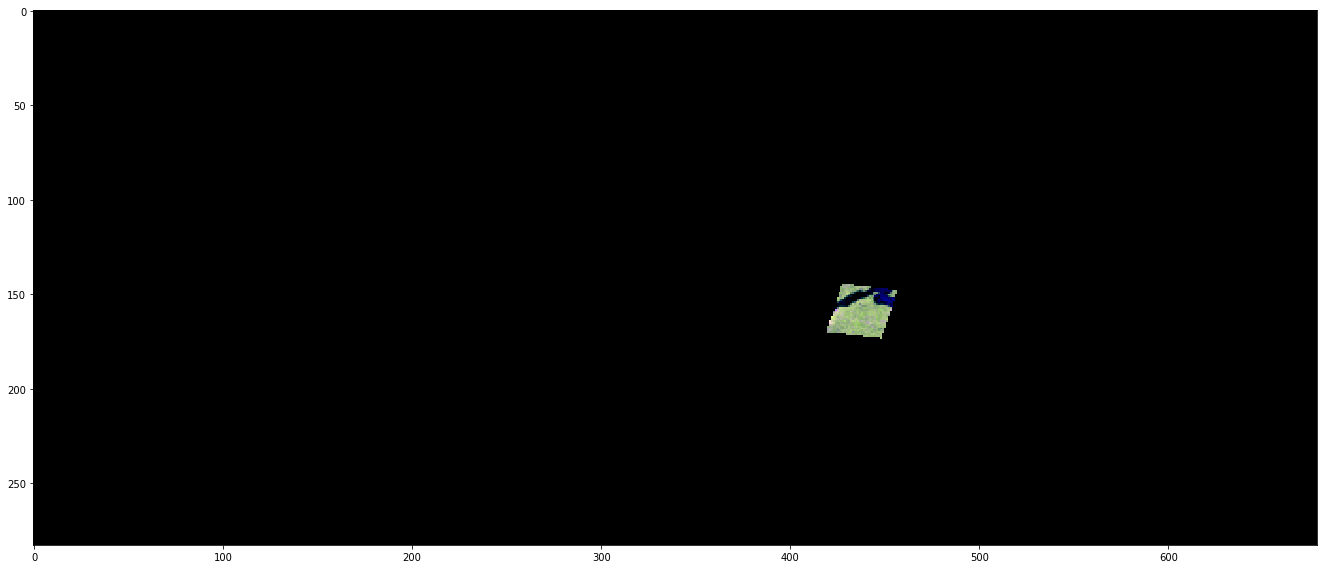

In [12]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (23, 23)
#---------------------------------------------------
s1.visualise_rgb(shrink_factor=15)

### 8* - Create thumbnail image

For some it might be interesting to create a small thumbnail image in Jpeg format. The *create_rgb_thumbnail* method allows for this. 

In [13]:
# define a filename for our thumbnail image
path_to_thumbnail = join(output_dir, '{}.TN.jpg'.format(s1.start_date))
# create the thumbnail image
s1.create_rgb_thumbnail(outfile = path_to_thumbnail)

'/home/suprd/OpenSarToolkit/Tutorial_1/20180813.TN.jpg'

4,0K /home/suprd/OpenSarToolkit/Tutorial_1/20180813.TN.jpg


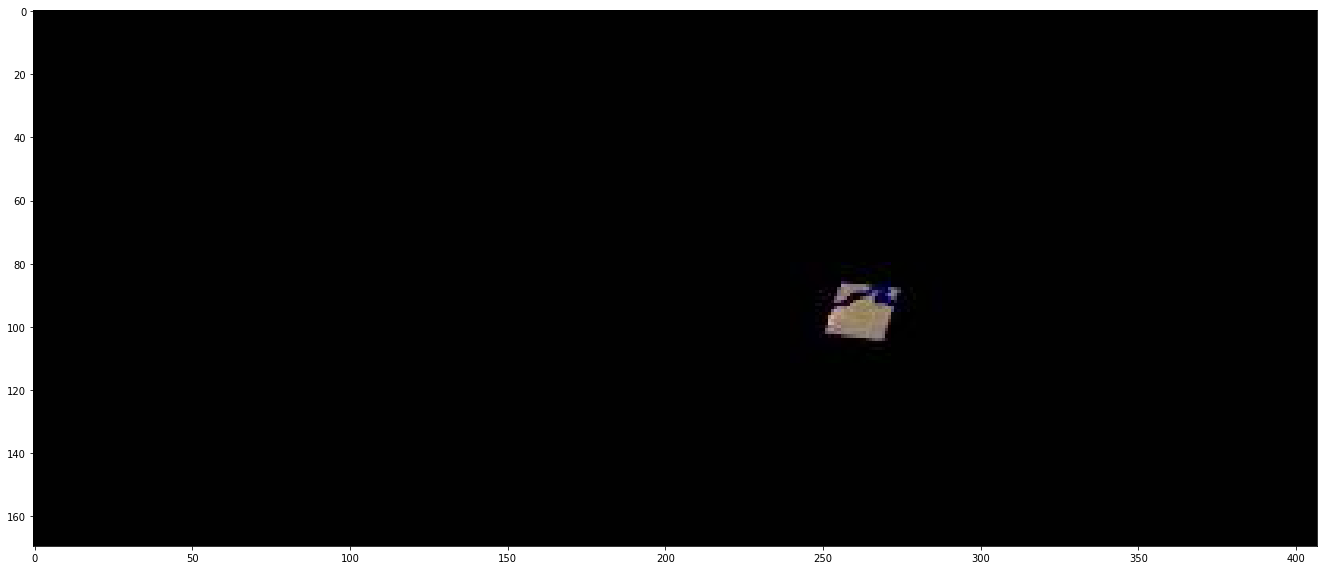

In [14]:
import imageio
img = imageio.imread(path_to_thumbnail)
!ls -sh {path_to_thumbnail}
plt.imshow(img)